In [41]:
#importing python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing

import kagglehub
from kagglehub import KaggleDatasetAdapter


In [42]:
#Loading the dataset
df = pd.read_csv('uber.csv')
df.info()

file_path = "uber.csv"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17848 entries, 0 to 17847
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         17848 non-null  int64  
 1   key                17848 non-null  object 
 2   fare_amount        17847 non-null  float64
 3   pickup_datetime    17847 non-null  object 
 4   pickup_longitude   17847 non-null  float64
 5   pickup_latitude    17847 non-null  float64
 6   dropoff_longitude  17847 non-null  float64
 7   dropoff_latitude   17847 non-null  float64
 8   passenger_count    17847 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ MB


In [43]:
#Desciptive Statistics
df.describe()


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.784800e+04,17847.000000,17847.000000,17847.000000,17847.000000,17847.000000,17847.000000
mean,2.765310e+07,11.417429,-72.595005,39.951854,-72.580938,39.952298,1.672830
std,1.599173e+07,10.173691,11.458450,6.095753,10.197475,6.096021,1.295875
min,4.800000e+01,2.500000,-748.016667,-74.009697,-75.350437,-74.008745,0.000000
25%,1.383501e+07,6.000000,-73.992000,40.734977,-73.991591,40.733933,1.000000
50%,2.755475e+07,8.500000,-73.981823,40.752377,-73.980073,40.752884,1.000000
75%,4.140304e+07,12.500000,-73.967328,40.767152,-73.963307,40.768318,2.000000
max,5.542169e+07,350.000000,40.770667,41.366138,40.828377,41.366138,6.000000


In [44]:
#Cleaning dataset
columns_to_drop = ['Unnamed: 0', 'key']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df = df.drop(existing_columns, axis=1)

In [45]:
df.isna().sum()


,0
fare_amount,1
pickup_datetime,1
pickup_longitude,1
pickup_latitude,1
dropoff_longitude,1
dropoff_latitude,1
passenger_count,1


In [46]:
#Drop null values
df.dropna(axis=0,inplace=True)

In [47]:
df.dtypes

,0
fare_amount,float64
pickup_datetime,object
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,float64


In [48]:
#Converts a column to object
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [49]:
#Seperating the Date & Time
df= df.assign(
second = df.pickup_datetime.dt.second,
minute = df.pickup_datetime.dt.minute,
hour = df.pickup_datetime.dt.hour,
day= df.pickup_datetime.dt.day,
month = df.pickup_datetime.dt.month,
year = df.pickup_datetime.dt.year,
dayofweek = df.pickup_datetime.dt.dayofweek
)
df = df.drop('pickup_datetime',axis=1)

In [50]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17847 entries, 0 to 17846
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        17847 non-null  float64
 1   pickup_longitude   17847 non-null  float64
 2   pickup_latitude    17847 non-null  float64
 3   dropoff_longitude  17847 non-null  float64
 4   dropoff_latitude   17847 non-null  float64
 5   passenger_count    17847 non-null  float64
 6   second             17847 non-null  int32  
 7   minute             17847 non-null  int32  
 8   hour               17847 non-null  int32  
 9   day                17847 non-null  int32  
 10  month              17847 non-null  int32  
 11  year               17847 non-null  int32  
 12  dayofweek          17847 non-null  int32  
dtypes: float64(6), int32(7)
memory usage: 1.4 MB


In [51]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,second,minute,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,6,52,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,56,4,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,0,45,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,21,22,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,0,47,17,28,8,2014,3


Haversine Formula

Calculating the distance between the pickup and drop co-ordinates using the haversine formula for accuracy

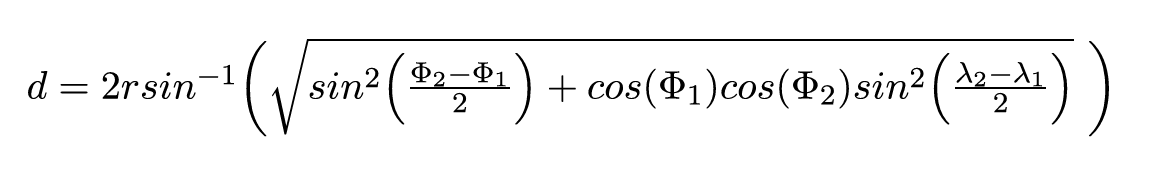

In [52]:
#haversine formula

incorrect_coordinates = df.loc[
(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
(df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
(df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
(df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
]
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [53]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
  long1, lati1, long2, lati2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])
  dist_long = long2 - long1
  dist_lati = lati2 - lati1
  a = np.sin(dist_lati/2)**2 + np.cos(lati1) * np.cos(lati2) * np.sin(dist_long/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) * 6371
  return c

In [54]:
df['Distance'] = distance_transform(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['dropoff_longitude'],
    df['dropoff_latitude']
)

In [55]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,second,minute,hour,day,month,year,dayofweek,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,6,52,19,7,5,2015,3,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,56,4,20,17,7,2009,4,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,0,45,21,24,8,2009,0,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,21,22,8,26,6,2009,4,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,0,47,17,28,8,2014,3,4.475450


Text(0, 0.5, 'fare_amount')

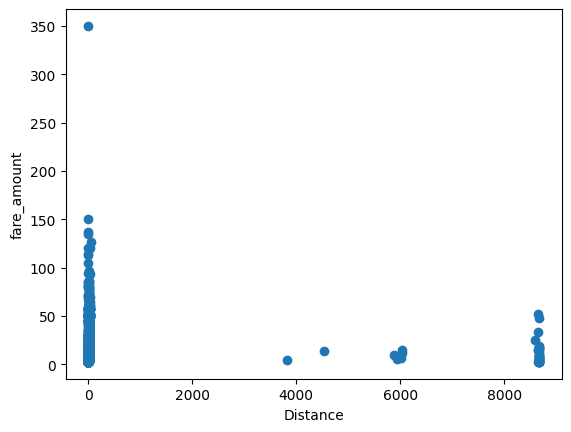

In [56]:
#Outliers
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

<Axes: >

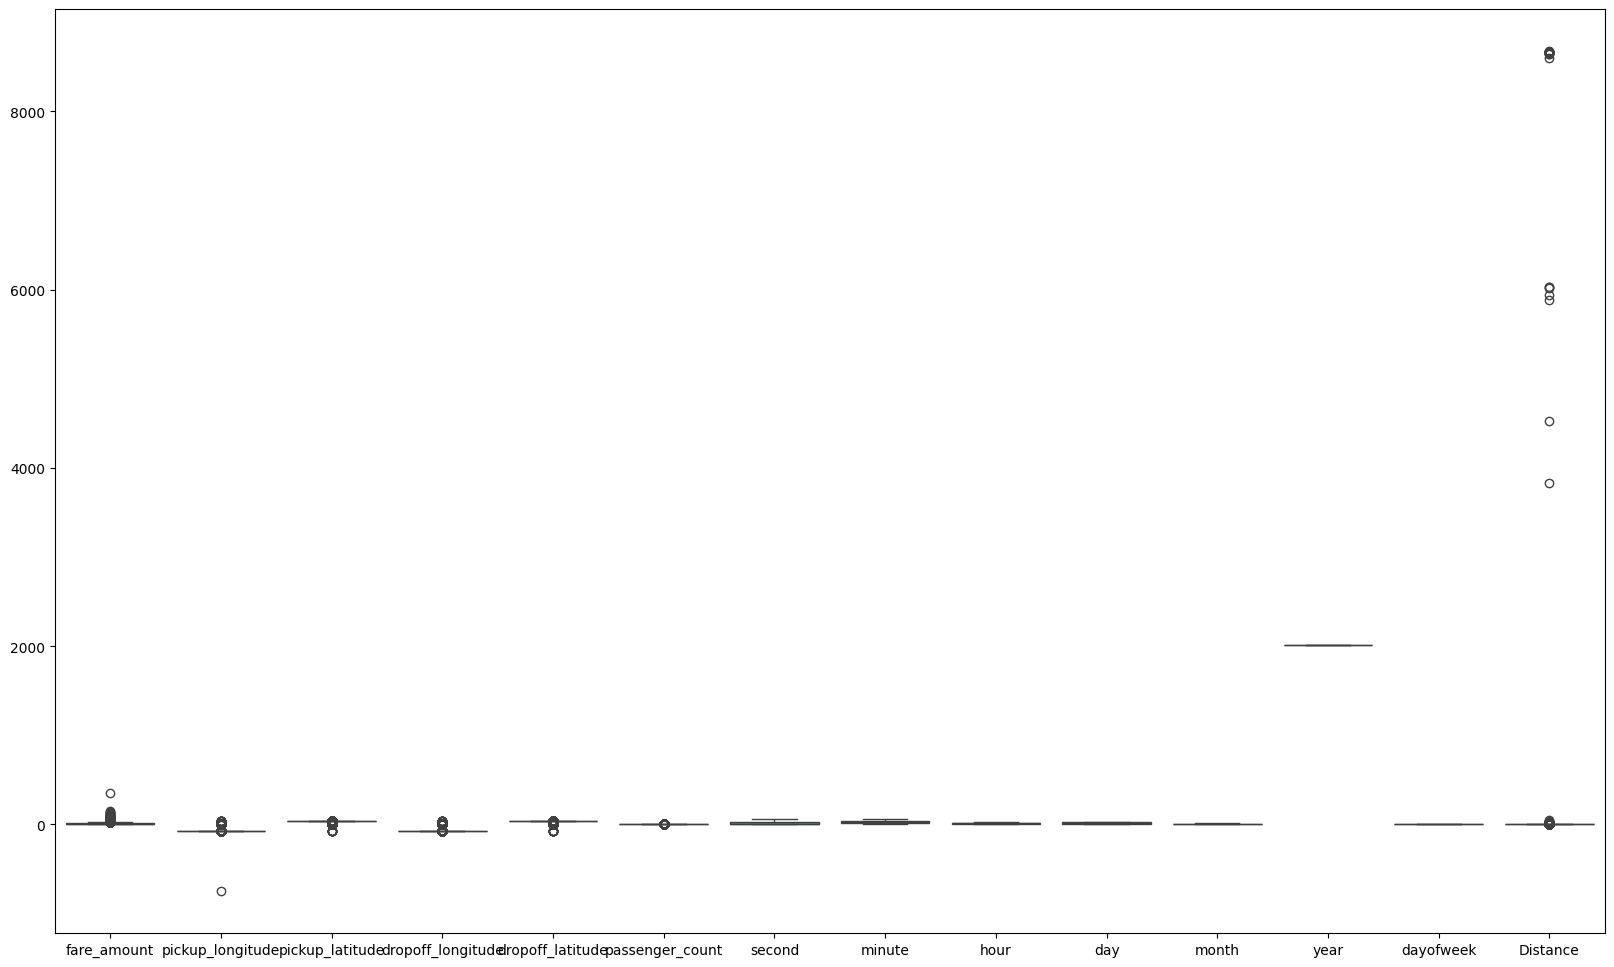

In [57]:
plt.figure(figsize=(20,12))
sns.boxplot(data = df)

In [58]:
df.drop(df[df['Distance'] >= 60].index, inplace = True)
df.drop(df[df['fare_amount'] <= 0].index, inplace = True)
df.drop(df[(df['fare_amount']>100) & (df['Distance']<1)].index, inplace = True )
df.drop(df[(df['fare_amount']<100) & (df['Distance']>100)].index, inplace = True )

Text(0, 0.5, 'fare_amount')

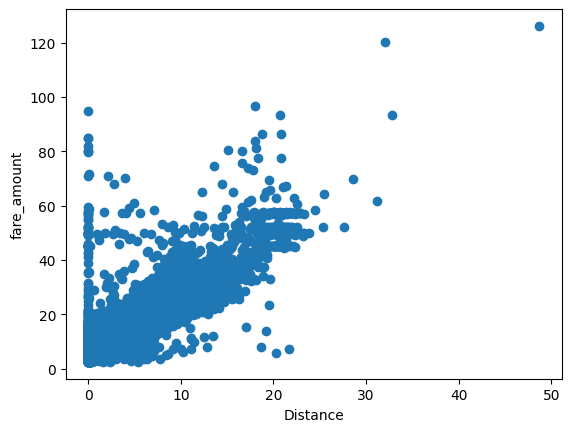

In [59]:
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [60]:
#coorelation
corr = df.corr()
corr.style.background_gradient(cmap='BuGn')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,second,minute,hour,day,month,year,dayofweek,Distance
fare_amount,1.000000,0.011058,-0.010620,0.010744,-0.010569,0.008514,-0.006353,-0.007230,-0.003587,-0.001046,0.029099,0.124357,0.011921,0.855590
pickup_longitude,0.011058,1.000000,-0.978635,0.999992,-0.978618,0.005076,-0.018881,0.011759,-0.003357,0.007920,-0.014126,0.002281,-0.016376,-0.111318
pickup_latitude,-0.010620,-0.978635,1.000000,-0.978642,0.999987,-0.009071,0.021698,-0.011255,0.007316,-0.012252,0.014966,-0.005746,0.012885,0.101323
dropoff_longitude,0.010744,0.999992,-0.978642,1.000000,-0.978626,0.005062,-0.018794,0.011740,-0.003647,0.007937,-0.014099,0.002297,-0.016308,-0.111493
dropoff_latitude,-0.010569,-0.978618,0.999987,-0.978626,1.000000,-0.009051,0.021692,-0.011182,0.007265,-0.012254,0.014957,-0.005712,0.012914,0.101562
passenger_count,0.008514,0.005076,-0.009071,0.005062,-0.009051,1.000000,-0.217071,0.012622,0.013671,0.007715,0.011920,0.003301,0.030506,0.014155
second,-0.006353,-0.018881,0.021698,-0.018794,0.021692,-0.217071,1.000000,-0.011483,-0.009642,-0.001793,-0.055334,0.079914,0.002239,-0.006970
minute,-0.007230,0.011759,-0.011255,0.011740,-0.011182,0.012622,-0.011483,1.000000,0.007675,-0.001824,-0.002231,-0.004216,-0.015007,-0.014099
hour,-0.003587,-0.003357,0.007316,-0.003647,0.007265,0.013671,-0.009642,0.007675,1.000000,0.001317,0.001313,0.001086,-0.094099,-0.016315
day,-0.001046,0.007920,-0.012252,0.007937,-0.012254,0.007715,-0.001793,-0.001824,0.001317,1.000000,-0.021688,-0.014225,-0.003724,-0.000471


In [61]:
#standardization (for acurate results using Linear Regression)
x = df['Distance'].values.reshape(-1, 1)
y = df['fare_amount'].values.reshape(-1,1)


In [62]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
y_std = std.fit_transform(y)
print(y_std)

x_std = std.fit_transform(x)
print(x_std)

[[-0.40180516]
 [-0.38094327]
 [ 0.16146609]
 ...
 [ 1.58007517]
 [-0.67300984]
 [-0.03672194]]
[[-0.43899682]
 [-0.22366223]
 [ 0.49353483]
 ...
 [ 1.69990844]
 [-0.42274548]
 [-0.64312305]]


In [63]:
#Splitting the dataset (Trainning & Testing Dataset)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=0)

In [64]:
#Linear Regression trainning to train the dataset
from sklearn.linear_model import LinearRegression
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
print("Training set score: {:.2f}".format(l_reg.score(X_train, y_train)))
print("Test set score: {:.7f}".format(l_reg.score(X_test, y_test)))

Training set score: 0.73
Test set score: 0.7316693


In [65]:
y_pred = l_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred
result.sample(10)

,Actual,Predicted
3181,-0.255772,0.236354
557,-0.506115,-0.422992
1096,-0.610424,-0.438555
1561,0.224052,0.640531
3233,-0.047153,0.326075
1034,0.203190,0.386870
525,1.371456,1.521532
2409,-0.297496,-0.299664
2112,0.067588,-0.475031
766,-0.141031,-0.095535


In [66]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:' ,np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared (R^2):', np.sqrt(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 0.26722036563873924
Mean Absolute % Error: 1.3303893172593673
Mean Squared Error: 0.2556415197241215
Root Mean Squared Error: 0.5056100470957055
R Squared (R^2): 0.8553767201239891


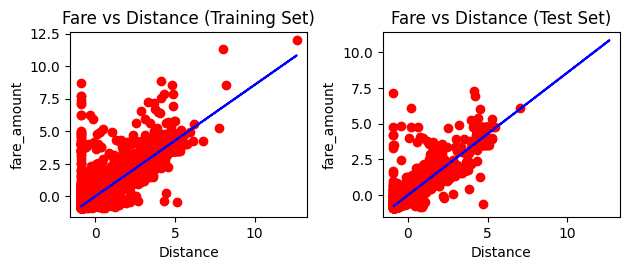

In [67]:
#Visualization

plt.subplot(2, 2, 1)
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.title("Fare vs Distance (Training Set)")
plt.ylabel("fare_amount")
plt.xlabel("Distance")

plt.subplot(2, 2, 2)
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.ylabel("fare_amount")
plt.xlabel("Distance")
plt.title("Fare vs Distance (Test Set)")

plt.tight_layout()
plt.show()

In [68]:
cols = ['Model', 'RMSE', 'R-Squared']
result_tabulation = pd.DataFrame(columns = cols)
linreg_metrics = pd.DataFrame([[
"Linear Regresion model",
np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
np.sqrt(metrics.r2_score(y_test, y_pred))
]], columns = cols)
result_tabulation = pd.concat([result_tabulation, linreg_metrics], ignore_index=True)
result_tabulation

/tmp/ipython-input-3674444731.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_tabulation = pd.concat([result_tabulation, linreg_metrics], ignore_index=True)


,Model,RMSE,R-Squared
0,Linear Regresion model,0.50561,0.855377


In [69]:
#Random Forest Regressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

rf_reg.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=10)

In [70]:
y_pred_RF = rf_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF
result.sample(10)

,Actual,Predicted
1501,-0.255772,0.141752
1689,-0.464391,-0.214883
2367,-0.141031,-0.341410
1249,-0.558269,-0.580905
3473,-0.756457,-0.700548
2290,-0.464391,-0.142596
2882,-0.422667,-0.170760
2892,-0.349650,-0.447075
2729,-0.005429,0.069674
1069,-0.714734,-0.574855


In [71]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_RF))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_RF))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_RF))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print('R Squared (R²):', np.sqrt(metrics.r2_score(y_test, y_pred_RF)))

Mean Absolute Error: 0.30523040728062484
Mean Absolute % Error: 1.4662375330710717
Mean Squared Error: 0.3064256145128713
Root Mean Squared Error: 0.5535572368896204
R Squared (R²): 0.8236288572442263


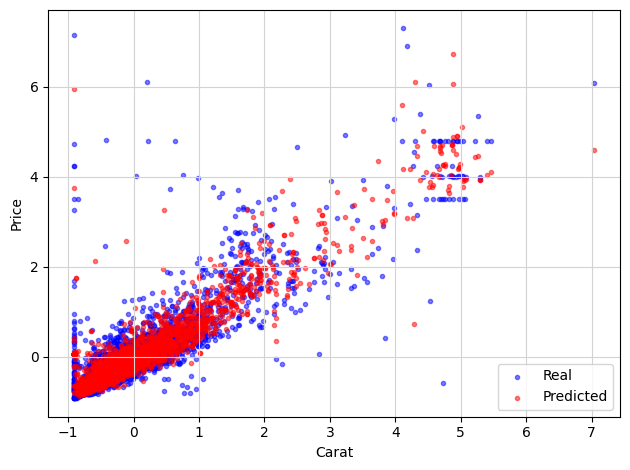

In [72]:
#Visualization
plt.scatter(X_test, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X_test, y_pred_RF, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()